## Description 

We have an A/B test in our network from 13-06-2022 to 19-06-2022. 

The 1st group was the control. In group #2 (test group) was used a new algorithm of post-recommendation. 

The main hypothesis is that the new algorithm will lead to an increase in CTR.


# Contents

* [Connection](#conn)
* [Checking A/A test](#aa)
* [Analyze A/B test](#ab)
    * [T-test](#ttest)
* [Comparing results of statistical tests](#compare)
    * [Mann-Whitney](#mann)
    * [Smoothed CTR](#smoothed)
    * [Poisson bootstrap](#bootstrap)
    * [Bucket testing](#bucket)
    * [Linearization](#lin)
* [Conclusion](#conc)

<a id = 'conn'></a>
## Connection

We created a special file with configuration information (host, database, and so on). With a help of the library <code>configparser</code>, were read necessary parameters.

In [1]:
import configparser

import pandas as pd
import pandahouse as ph

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import numpy as np

In [2]:
# import and parse configs data for connection to database
config = configparser.ConfigParser()
config.read('configs.ini')

connection = {
    'host': config['db']['host'],
    'database': config['db']['database'],
    'user': config['db']['user'],
    'password': config['db']['password']
}

In [3]:
def run_query(query, connection = connection):
    df = ph.read_clickhouse(query, connection=connection)
    return df

<a id = 'aa'> </a>
## Checking A/A test

We need to start our analysis by making sure that our system splitting works correctly and that our crucial metric isn't different neither at our test in groups 0 and 1 nor in general.

In the best case, it will be good to spend an infinite amount of AA tests and see in how many cases will we deny the null hypothesis.

If the splitting system works correctly, then statistically significant differences between the two groups will be in the random false results. For example, if we accept the null hypothesis with the condition of p-value less than 0,05, then around 5% of cases will have statistically significant differences between the two groups.

We have data from the AA-test. We need to simulate 10 000 AA-tests with samples of 500 users and then we need to compare this data with t-tests.

In [4]:
query_aa_test = """
SELECT user_id,
        countIf(action='like') as likes,
        countIf(action='view') as views,
        likes/views as ctr,
        exp_group
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-06' and toDate(time) <= '2022-06-12' 
GROUP BY user_id, exp_group
"""

In [5]:
aa_test = run_query(query_aa_test)
aa_test

,user_id,likes,views,ctr,exp_group
0,115383,11,36,0.305556,3
1,18392,8,39,0.205128,1
2,123580,15,92,0.163043,3
3,131473,26,148,0.175676,2
4,107323,5,26,0.192308,4
...,...,...,...,...,...
42580,122758,37,212,0.174528,3
42581,132567,15,81,0.185185,1
42582,122190,25,74,0.337838,3
42583,108927,8,33,0.242424,2


In [6]:
aa_test.groupby('exp_group').user_id.count()

exp_group
0    8484
1    8537
2    8480
3    8569
4    8515
Name: user_id, dtype: int64

We see that our groups are divided into almost equal parts. Differences are around 1%.

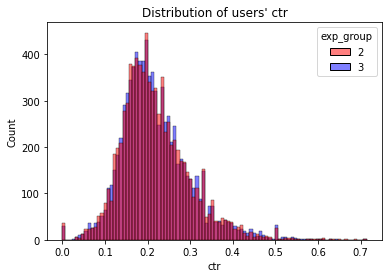

In [7]:
sns.histplot(
            data = aa_test[aa_test['exp_group'].isin([2,3])],
             x ='ctr',
             hue = 'exp_group',
            palette=['r','b'],
            alpha=0.5)
plt.title("Distribution of users' ctr");

In [8]:
res = []
for i in range(10000):
    a1 = aa_test[aa_test['exp_group'] == 2].sample(500, replace=True)
    a2 = aa_test[aa_test['exp_group'] == 3].sample(500, replace=True)
    res.append(
            stats.ttest_ind(a1.ctr, a2.ctr, equal_var= False)[1])


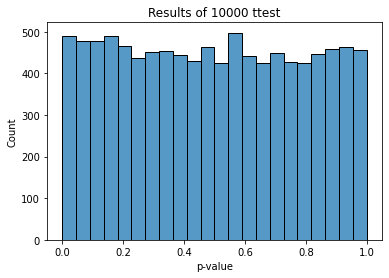

In [9]:
sns.histplot(data=res)
plt.title('Results of 10000 ttest')
plt.xlabel('p-value');  

In [10]:
result = pd.Series(res)
result[result<=0.05].count() / len(result) * 100

5.4

Among 10 000 tests, around 5% of cases were reasons for denying the null hypothesis about the equality of an average CTR. Consequently, we can consider our system of splitting worked correctly.

<a id = 'ab'> </a>
## Analyze A/B test

Let's start our A/B test analysis.

In [11]:
query_ab_test = """
SELECT user_id,
        countIf(action='like') as likes,
        countIf(action='view') as views,
        likes/views as ctr,
        exp_group
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'  and exp_group in (2,1)
GROUP BY user_id, exp_group
"""

In [12]:
ab_test = run_query(query_ab_test, connection)
ab_test

,user_id,likes,views,ctr,exp_group
0,109963,3,15,0.200000,1
1,26117,32,141,0.226950,1
2,138232,18,73,0.246575,1
3,26295,33,122,0.270492,1
4,18392,7,32,0.218750,1
...,...,...,...,...,...
20026,132567,45,296,0.152027,1
20027,30872,11,59,0.186441,1
20028,25383,42,127,0.330709,2
20029,139020,24,114,0.210526,2


In [13]:
ab_test.to_csv('ab_test')

<a id = 'ttest'> </a>
### T-test

H0: Average CTRs will be equal in the two groups.
    
H1: New algorithm will increase CTR in the second group. The average meaning in the test group will be greater.
    

In [14]:
a = ab_test[ab_test['exp_group'] == 1]['ctr']
b = ab_test[ab_test['exp_group'] == 2]['ctr']

In [15]:
a.mean(), b.mean()

(0.21560459841296287, 0.21441927347479375)

As we can see the meanings are almost similar.

In [16]:
def conclusion_of_the_test(pvalue, alpha = 0.05):
    if pvalue > alpha:
        print('No reasons for denying the null hypothesis')
    else:
        print('We have reasons for denying the null hypothesis' )
    print('p-value:', pvalue)

In [17]:
res = stats.ttest_ind(a, b, equal_var= False, alternative = 'less')
conclusion_of_the_test(res[1])

No reasons for denying the null hypothesis
p-value: 0.7609688434562533


In the first view, we don't have reasons for denying the null hypothesis. Let's look at different tests and visualizations

<a id='compare'></a>
## Comparing results of statistical tests

In this study case, we won't consider the problem of multiply comparing.

###  Visualization of distribution

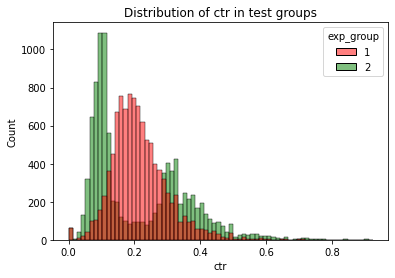

In [18]:
sns.histplot(
    data = ab_test,
    x = 'ctr',
    hue = 'exp_group',
    palette = ['r','g'],
    alpha = 0.5
)
plt.title('Distribution of ctr in test groups');
    

Judging by the image of distribution, differences between test and control groups are present. But it isn't that simple, as we wished. Part of the users increased their CTR and part decreased.

<a id = 'mann'></a>
### Mann–Whitney test

In [19]:
res_mann = stats.mannwhitneyu(a,b)
conclusion_of_the_test(res_mann[1])

We have reasons for denying the null hypothesis
p-value: 6.0376484617779035e-56


Mann-Whitney test managed to notice the differences. 

<a id = 'smoothed'></a>
### Smoothed CTR

We know almost nothing about the CTR of users, who have only several views, independently from the number of clicks.

Get "smoothed" our CTR rate (the procedure name is Laplace smoothing).

$$smoothed_{u}CTR = \frac{clicks_{u} + \alpha * globalCTR}{views_{u}+\alpha}$$

where α — hyperparameter

The main idea: when we have a big number of views, smoothed CTR is almost equal to user CTR. When views are little, smoothed CTR is almost equal to group-wide CTR.

BUT! We don't have a theoretical guarantee, that the orientation of the smoothed CTR will match with the orientation of the main number of clicks.

In [20]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [21]:
group_ctr_1 = ab_test[ab_test['exp_group'] == 1].likes.sum() / ab_test[ab_test['exp_group'] == 1].views.sum()
group_ctr_2 = ab_test[ab_test['exp_group'] == 2].likes.sum() / ab_test[ab_test['exp_group'] == 2].views.sum()

In [22]:
group_1_copy = ab_test[ab_test['exp_group']==1].copy()

In [23]:
group_1_copy['smothed_ctr'] = ab_test.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], group_ctr_1, 5), axis=1)

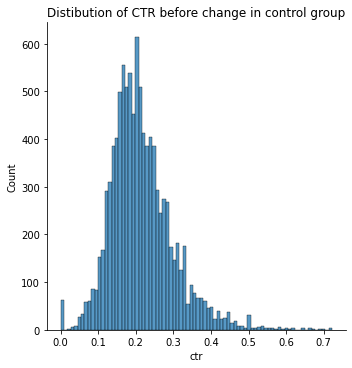

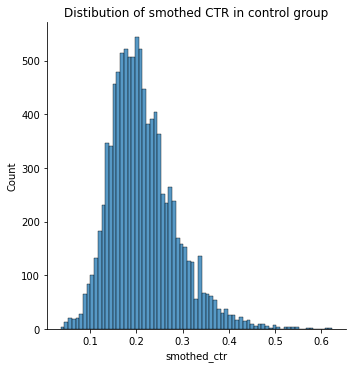

In [24]:
sns.displot(group_1_copy.ctr,kde=False);
plt.title('Distibution of CTR before change in control group');
sns.displot(group_1_copy.smothed_ctr,kde=False);
plt.title('Distibution of smothed CTR in control group');

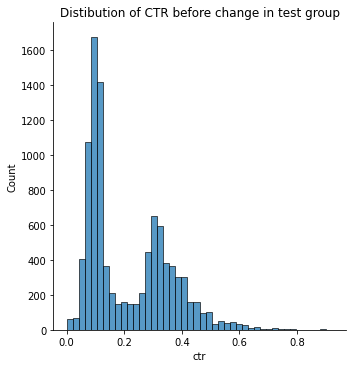

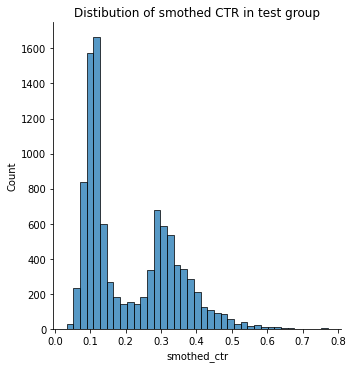

In [25]:
group_2_copy = ab_test[ab_test['exp_group']== 2].copy()
group_2_copy['smothed_ctr'] = ab_test.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], group_ctr_1, 5), axis=1)

sns.displot(group_2_copy.ctr,kde=False);
plt.title('Distibution of CTR before change in test group');

sns.displot(group_2_copy.smothed_ctr,kde=False);
plt.title('Distibution of smothed CTR in test group');

H0: Average values of smoothed CTR are equal in both groups.

H1: Average values of smoothed CTR are different in both groups.


In [26]:
group_2_copy['smothed_ctr'].mean(), group_1_copy['smothed_ctr'].mean()

(0.21181083533531964, 0.21402549608884142)

In [27]:
res = stats.ttest_ind(group_2_copy['smothed_ctr'], 
                        group_1_copy['smothed_ctr'], 
                        equal_var=False)
conclusion_of_the_test(res[1])

No reasons for denying the null hypothesis
p-value: 0.12398006885092346


Smoothed CTR T-test tells us that there is no reason for denying the null hypothesis about equality average meaning.

In [28]:
res = stats.mannwhitneyu(group_2_copy['smothed_ctr'], 
                group_1_copy['smothed_ctr'])
conclusion_of_the_test(res[1])

We have reasons for denying the null hypothesis
p-value: 8.103385180023362e-58


But test Mann-Whitney has already seen the differences. 

<a id = 'bootstrap'></a>
## Poisson bootstrap

We take a sample from group A. From the Poisson distribution, we generate “how many times this user got into the pseudo-sample”. It creates a column that reflects the "weight" of the user. We calculate the "global CTR" by pseudo-sample for AA:

$$globalCTR_{i} = \frac{sum(clicks_{i}*weights_{j})}{sum(views_{i}*weights_{j})}$$

We do the same for the sample from group B.

We consider the difference between globalCTR_A - globalCTR_B and write down this difference. We repeat the procedure many times. So we're collecting in the distribution for the difference in global CTR.

In [29]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [30]:
likes1 = ab_test[ab_test.exp_group == 1].likes.to_numpy()
views1 = ab_test[ab_test.exp_group == 1].views.to_numpy()
likes2 = ab_test[ab_test.exp_group == 2].likes.to_numpy()
views2 = ab_test[ab_test.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

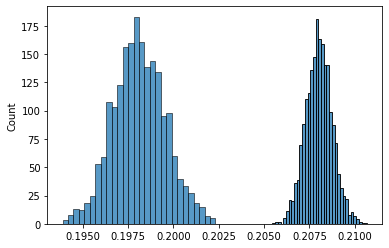

In [31]:
sns.histplot(ctr1)
sns.histplot(ctr2)

In [32]:
res = stats.ttest_ind(ctr1, ctr2, equal_var= False)
conclusion_of_the_test(res[1])

We have reasons for denying the null hypothesis
p-value: 0.0


<AxesSubplot:ylabel='Count'>

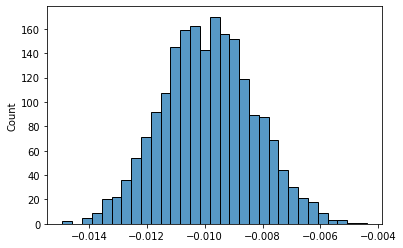

In [33]:
sns.histplot(ctr2 - ctr1)

As we can see, the difference doesn't intersect 0. Consequently, the CTR of the control group is bigger than the CTR of the test group. And that means the influence of our new algorithm is present but on the negative side.   

<a id ='bucket'></a>
## Bucket testing 

When we divide our initial sample into a certain number of buckets, and calculate, for example, the average in each bucket, we get a sample of 50 values of the average for these “meta users” at the output. It's like we made a bootstrap, but not by generating a pseudo-sample, but by biting off a piece from the existing one in the right way.

In [34]:
query_bucket = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
    
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'  and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

In [35]:
bucket = run_query(query_bucket)
bucket

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271
...,...,...,...
95,2,47,0.195880
96,1,48,0.212787
97,2,48,0.194502
98,1,49,0.203169


In [36]:
bucket[bucket.exp_group == 1].bucket_ctr.mean(), bucket[bucket.exp_group == 2].bucket_ctr.mean()

(0.20812170724336013, 0.19825944666552928)

In [37]:
res = stats.ttest_ind(bucket[bucket.exp_group == 1].bucket_ctr, 
                   bucket[bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)
conclusion_of_the_test(res[1])

We have reasons for denying the null hypothesis
p-value: 3.4455951649945907e-07


In [38]:
stats.mannwhitneyu(bucket[bucket.exp_group == 1].bucket_ctr, 
                   bucket[bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')
conclusion_of_the_test(res[1])

We have reasons for denying the null hypothesis
p-value: 3.4455951649945907e-07


The differences in the T-test and Mann-Whitney test are present. Consequently, the new algorithm influenced users' CTR.

<a id = 'lin'></a>
## Linearization

<b>Idea:</b> Instead of using users' CTR, we can create a new metric and analyze it. BUT here we have a guarantee that if the test shows differences in our metric, that means our initial  metric also was different.

We calculate the total CTR in the control group: $𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)$

Then calculate the user metric: $\text{𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠}=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠$

After it, we compare the differences in the groups by the metric.

In [39]:
q = """
SELECT user_id,
        countIf(action='like') as likes,
        countIf(action='view') as views,
        likes/views as ctr,
        exp_group
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'  
GROUP BY user_id, exp_group
"""
df = run_query(q)
df

,user_id,likes,views,ctr,exp_group
0,115383,9,30,0.300000,3
1,18392,7,32,0.218750,1
2,123580,13,48,0.270833,3
3,131473,14,134,0.104478,2
4,107323,5,31,0.161290,4
...,...,...,...,...,...
50144,27030,8,39,0.205128,0
50145,122758,30,198,0.151515,3
50146,132567,45,296,0.152027,1
50147,122190,19,65,0.292308,3


In [40]:
control_CTR = df[df['exp_group']==0].likes.sum() / df[df['exp_group']==0].views.sum()
control_CTR

0.20823612262916305

In [41]:
df['linearized_likes'] = df.likes - control_CTR * df.views
df.head()

,user_id,likes,views,ctr,exp_group,linearized_likes
0,115383,9,30,0.300000,3,2.752916
1,18392,7,32,0.218750,1,0.336444
2,123580,13,48,0.270833,3,3.004666
3,131473,14,134,0.104478,2,-13.903640
4,107323,5,31,0.161290,4,-1.455320


In [42]:
group_0 = df[df['exp_group'] == 0]
group_1 = df[df['exp_group'] == 1]
group_2 = df[df['exp_group'] == 2]
group_3 = df[df['exp_group'] == 3]

In [43]:
# t-test raw data CTR 
res = stats.ttest_ind(group_0.ctr, group_3.ctr, equal_var = False)
conclusion_of_the_test(res[1])

We have reasons for denying the null hypothesis
p-value: 1.055849414662529e-43


In [44]:
# t-test lin.likes
res =stats.ttest_ind(group_0.linearized_likes, group_3.linearized_likes, equal_var = False)
conclusion_of_the_test(res[1])

We have reasons for denying the null hypothesis
p-value: 5.4914249479690016e-52


T-test "sees" the differences in average meanings of new metrics of linearized likes. It means we have enough reasons to reject the null hypothesis about equality of average values.

In [45]:
# t-test raw data CTR
res = stats.ttest_ind(group_1.ctr, group_2.ctr, equal_var = False)
conclusion_of_the_test(res[1])

No reasons for denying the null hypothesis
p-value: 0.4780623130874935


In [46]:
# t-test lin.likes
res = stats.ttest_ind(group_1.linearized_likes, group_2.linearized_likes, equal_var = False)
conclusion_of_the_test(res[1])

We have reasons for denying the null hypothesis
p-value: 9.544973454280379e-10


In the second case T-test also tells us about enough reasons to reject the null hypothesis, unlike the raw CTR test.

In both cases, the p-value has decreased and it confirms the statement about a more sensitive metric.

<a id = 'conc'></a>
## Conclusion

Most of all statistical tests see the difference between the test and the control groups. The Exception is a t-test on raw data and in the smoothed CTR. It could be connected with the kind of CTR distribution in the test group. After implement of the new algorithm, the distribution became bimodal. Perhaps, it is connected with the character of the algorithm influence: someone likes seeing new posts, and someone dislikes, and that's why the clickability changed in this way.